In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:11<00:00, 2.32MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 148kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 2.58MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 8.33MB/s]


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


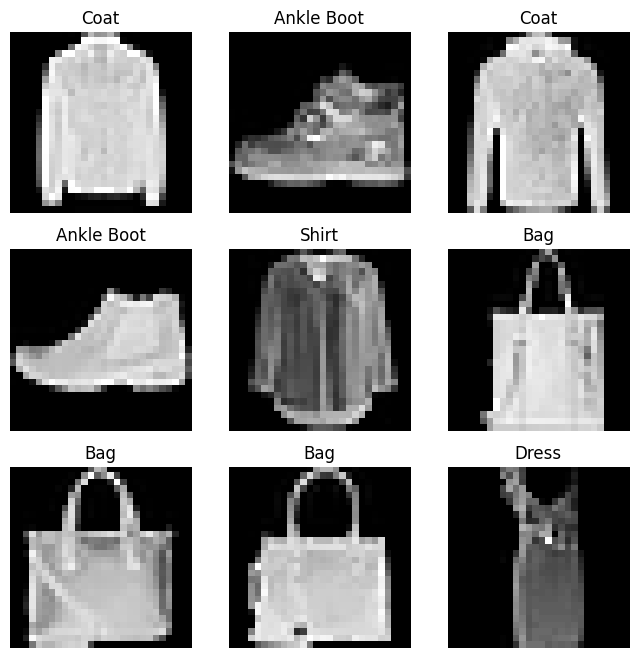

In [6]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 7
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.287664  [   64/60000]
loss: 2.281096  [ 6464/60000]
loss: 2.261832  [12864/60000]
loss: 2.257673  [19264/60000]
loss: 2.238972  [25664/60000]
loss: 2.197841  [32064/60000]
loss: 2.200053  [38464/60000]
loss: 2.163627  [44864/60000]
loss: 2.166553  [51264/60000]
loss: 2.116787  [57664/60000]
Test Error: 
 Accuracy: 47.0%, Avg loss: 2.124007 

Epoch 2
-------------------------------
loss: 2.130534  [   64/60000]
loss: 2.122222  [ 6464/60000]
loss: 2.063462  [12864/60000]
loss: 2.080189  [19264/60000]
loss: 2.018030  [25664/60000]
loss: 1.949316  [32064/60000]
loss: 1.968537  [38464/60000]
loss: 1.891466  [44864/60000]
loss: 1.896748  [51264/60000]
loss: 1.797607  [57664/60000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.818426 

Epoch 3
-------------------------------
loss: 1.847863  [   64/60000]
loss: 1.816832  [ 6464/60000]
loss: 1.705774  [12864/60000]
loss: 1.745859  [19264/60000]
loss: 1.625864  [25664/60000]
loss: 1.586514  [32064/600

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [16]:
for i in range(100):  # Test first 5 examples
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Example {i} — Predicted: "{predicted}", Actual: "{actual}"')


Example 0 — Predicted: "Ankle boot", Actual: "Ankle boot"
Example 1 — Predicted: "Pullover", Actual: "Pullover"
Example 2 — Predicted: "Trouser", Actual: "Trouser"
Example 3 — Predicted: "Trouser", Actual: "Trouser"
Example 4 — Predicted: "Shirt", Actual: "Shirt"
Example 5 — Predicted: "Trouser", Actual: "Trouser"
Example 6 — Predicted: "Shirt", Actual: "Coat"
Example 7 — Predicted: "Coat", Actual: "Shirt"
Example 8 — Predicted: "Sneaker", Actual: "Sandal"
Example 9 — Predicted: "Sneaker", Actual: "Sneaker"
Example 10 — Predicted: "Pullover", Actual: "Coat"
Example 11 — Predicted: "Sandal", Actual: "Sandal"
Example 12 — Predicted: "Sneaker", Actual: "Sneaker"
Example 13 — Predicted: "Dress", Actual: "Dress"
Example 14 — Predicted: "Coat", Actual: "Coat"
Example 15 — Predicted: "Trouser", Actual: "Trouser"
Example 16 — Predicted: "Pullover", Actual: "Pullover"
Example 17 — Predicted: "Pullover", Actual: "Coat"
Example 18 — Predicted: "Bag", Actual: "Bag"
Example 19 — Predicted: "T-shirt

In [17]:
import random

i = random.randint(0, len(test_data) - 1)
x, y = test_data[i][0], test_data[i][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Random Example {i} — Predicted: "{predicted}", Actual: "{actual}"')


Random Example 8034 — Predicted: "T-shirt/top", Actual: "T-shirt/top"
